In [1]:
from sklearn.metrics import (auc,
                             roc_curve,
                             roc_auc_score, 
                             RocCurveDisplay,
                             silhouette_score,
                             confusion_matrix, 
                             classification_report,
                             PrecisionRecallDisplay,
                             precision_recall_curve,)
        
from sklearn.model_selection import (GridSearchCV,
                                     cross_val_score,
                                     StratifiedKFold,
                                     validation_curve,
                                     train_test_split, )

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn.svm import SVC
import seaborn as sns
import pandas as pd
import numpy as np
import joblib

In [2]:
ifood_clf = joblib.load('ifood-pipeline.pkl')
X_val = pd.read_pickle('X_validation.pkl')
y_val = pd.read_pickle('y_validation.pkl')
X_train = pd.read_pickle('X_train.pkl')
y_train = pd.read_pickle('y_train.pkl')
X = pd.read_pickle('X.pkl')
y = pd.read_pickle('y.pkl')

## Using Binary Encoding

Before jumping into creating a pipeline, let's talk about transformation of non-numerical variables. The categorical variables need to be converted to numerical values to allow for the use of the predictive machine algorithms. And from the iFood data, these categorical variables are `'Education'` and `'Marital_Status'` which five and eight categories respectively. 

In [3]:
X[['Education', 'Marital_Status']].nunique()

Education         5
Marital_Status    8
dtype: int64

Note that these variables are nominal data, that is, the categories do not have an inherent order. Therefore, we could use one-hot encoding, binary encoding, or any other encoding that could be dimmed fit. In this case study the **binary encoding method** will be used. This encoding is similar to onehot, but stores categories as binary bitstrings. That is to say, binary encoding is a combination of Hash encoding and one-hot encoding. In this encoding scheme, the categorical feature is first converted into numerical using an ordinal encoder. Then the numbers are transformed in the binary number. After that binary value is split into different columns. Binary encoding works really well when there are a high number of categories thus it is a memory-efficient encoding scheme as it uses fewer features than one-hot encoding. Further, it reduces the curse of dimensionality for data with high cardinality. Note that here a total of seven features are added as opposed to the eleven that could be added should we've used one-hot encoding.

In [4]:
# Encoding the categorical variables
categ_ftrs = ['Education', 'Marital_Status']
categ_encoder = ce.BinaryEncoder(cols=categ_ftrs, return_df=True)
ifood_encoded = categ_encoder.fit_transform(X)

# Selecting the categorical columns and displaying them
encoded_categs = (list(ifood_encoded.filter(regex='Education')
                       .columns) + 
                  list(ifood_encoded.filter(regex='Marital_Status')
                       .columns))

ifood_encoded[encoded_categs].head(3)

,Education_0,Education_1,Education_2,Marital_Status_0,Marital_Status_1,Marital_Status_2,Marital_Status_3
0,0,0,1,0,0,0,1
1,0,0,1,0,0,0,1
2,0,0,1,0,0,1,0


## Explaining the Scores

**Precision:** Precision is the number of true positives divided by the sum of all positive predictions. It is also called the **positive predictive value**. High precision means having a lower false positive rate. 

$$\text{Precision = } \frac{\text{True Positive}}{\text{True Positive + False Positive}}$$

In our case, this is the number of correctly labeled clients who did agree to the campaign's offer  divided by the total number of customers classified as those who agreed. In other words, correctly labeled 1s divided by the total of customers classified to be in 1s. 

Why might precision be a useful measure of classifier performance? Imagine that for every positive model prediction, we are going to take some expensive course of action, such as a time-consuming review of content that was flagged as inappropriate by an automated procedure. False positives would waste the valuable time of human reviewers. We would want to be sure that we were making the right decisions on what content received a detailed review. Precision could be a good metric to use in this situation. 

**Recall:** Recall is the number of true positives divided by the sum of true positives and false negatives. This is also called **sensitivity**. 

$$\text{Recall = } \frac{\text{True Positive}}{\text{True Positive + False Negative}}$$

High recall reflects a lower false negative rate. For our classifier, it means predicting most 1s correctly.

**F1 score:** The F1-score is the harmonic mean of precision and recall. This metric gives equal weight to precision and recall, therefore it factors in both the number of errors made by the model and the type of errors. 

$$\text{F1 Score = } 2 \times \frac{\text{ Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$$

The F1 score favors models with similar precision and recall, and is a useful metric if we are seeking a model which performs reasonably well across both metrics.

## Logistic Model

Logistic model calculates the probability, $p$, that an observation belongs to a binary class. Using our ifood dataset as an example, if $p\geq 0.5$, we label the data as one, representing a prediction that an individual is more likely to accept the campaign's offer; if $p\leq 0.5$, we label it zero to represent that they are more likely to not accept the campaign's offer. We can predict probabilities of each instance belonging to a class by calling logistic regression's `.predict_proba()` method and passing the test features. This returns a 2-dimensional array with probabilities for both classes, in this case, that the individual did not accept the campaign's offer, or did accept, respectively. We slice the second column, representing the probabilities of those who did not accept the campaign's offer. Here we see the model predicts a probability of 0.015 that the first customer has accepted the campaign's offer.

In [5]:
logreg = ifood_clf.fit(X_train, y_train)
y_pred_proba = logreg.predict_proba(X_val)[:, 1]
y_pred_proba[0]

0.01504648655079792

### Probability Thresholds and ROC Curve

Deciding on a threshold for a classifier is a quite challenging because we have to pick where we are successfully recovering enough true positives, without incurring too many false positives. As the threshold is lowered more and more, there will be more of both. A good classifier will be able to capture more true positives without the expense of a large number of false positives. The default probability threshold for logistic regression in sklearn is 0.5 and this also apply to other models such as KNN. So what happens as we vary this threshold? We can use a receiver operating characteristic, or ROC curve, to visualize how different thresholds affect true positive rates (y-axis) and false positive rates (x-axis). 

![](roc_curve_explained.png)

- Here, the dotted line represents a chance model, which randomly guesses labels. 

- If the threshold equals one ($p=1$), there are no positive predictions since a logistic regression only predicts probabilities strictly between 0 and 1 (endpoints not included). Since there are no positive predictions, the TPR and the FPR are both 0, so the ROC curve starts out at (0, 0). 

- As the threshold is lowered, the TPR will start to increase, hopefully faster than the FPR if it's a good classifier. When the threshold is lowered to zero ($p=0$), every sample is predicted to be positive, including all the samples that are, in fact, positive, but also all the samples that are actually negative (incorrectly predicting all negative values). This means the TPR is 1 but the FPR is also 1.

- If we vary the threshold, we get a series of different false positive and true positive rates. That is, in between these two extremes ($p=0, p=1$) are the reasonable options for where we may want to set the threshold, depending on the relative costs and benefits of true and false positives and negatives for the specific problem being considered. In this way, it is possible to get a complete picture of the performance of the classifier at all different thresholds to decide which one to use.

In a "good" ROC curve, as we lower the threshold, we want to see the TPR increase, which means our classifier is doing a good job of correctly identifying positive samples. At the same time, ideally the FPR should not increase that much. The ROC curve of an effective classifier would hug the upper left corner of the plot: high TPR, low FPR. A perfect classifier would get a TPR of 1 (recovers all the positive samples) and an FPR of 0 and appear as a sort of square starting at (0,0), going up to (0,1), and finishing at (1,1). While in practice this kind of performance is highly unlikely, it gives us a limiting case. Values close to 0.5 indicate the model can do little better than random chance (coin flip) as a classifier, while values closer to 1 indicate better performance. The ROC AUC is a key metric for the quality of a classifier and is widely used in machine learning. The ROC AUC may also be referred to as the **C-statistic** (concordance statistic).

A line plot of the thresholds helps to visualize the trend. To visualize the ROC curve, we use the `roc_curve()` function where we pass the test labels as the first argument and the predicted probabilities as the second argument. The results are unpacked into three variables false positive rate, `fpr`; true positive rate, `tpr`; and the thresholds. We can then plot a dotted line from zero to one, along with the `fpr` and `tpr`. Here we just use a slight different method but the concept remains the same. We can see that the ROC curve starts at (0,0) with a threshold high enough so that there are no positive classifications. Then the first thing that happens, as we imagined previously when lowering the threshold to about 0.25, is that we get an increase in the TPR, but very little increase in the FPR. This means our classifier is doing a good job of correctly identifying positive samples. We can see the thresholds that lead to these rates by examining the threshold array, which is not part of the plot. One thing that is noticeable is that the first threshold is actually above 1; practically speaking, it just needs to be a threshold that's high enough that there are no positive classifications.

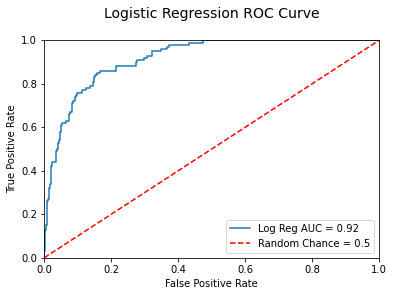

In [6]:
y_score = logreg.decision_function(X_val)
fpr, tpr, thresh = roc_curve(y_val, y_score, 
                             pos_label=logreg.classes_[1])

roc_display = (RocCurveDisplay(fpr=fpr, tpr=tpr)
               .plot(label='Log Reg AUC = %.02f'%(auc(fpr, tpr))))
plt.plot([0, 1], [0, 1], 'r--', label='Random Chance = 0.5')
plt.title('Logistic Regression ROC Curve\n', size=14)
plt.legend()
plt.axis([0, 1, 0, 1]);

### Precision Recall Curve

The precision diagnostic is useful over a range of threshold, that is, across the range of predicted probabilities, as we did for the ROC curve. At a high threshold there will be relatively few samples predicted as positive. As we lower the threshold more and more will be predicted as positive. Our hope is that as we do this, the number of true positives increases more quickly than the number of false positives as we saw on the ROC curve. Precision looks at the ratio of the number of true positives to the sum of true and false positives. 

$$\text{Precision = } \frac{\text{TP}}{\text{TP + FP}}$$

Think about the denominator here what is the sum of true and false positives? This sum is in fact the total number of positive predictions, since all positive predictions will be either correct or incorrect. So, precision measures the ratio of positive predictions that are correct to all positive predictions. For this reason, it is also called the positive predictive value. If there are very few positive samples, precision gives a more critical assessment of the quality of a classifier than the ROC AUC. As with the ROC curve, there is a convenient function in scikit-learn to calculate precision, together with recall (also known as the TPR), over a range of thresholds; `precision_recall_curve()`.

Precision and recall are often plotted together to assess the quality of positive predictions as far as what fraction are correct, while at the same time considering what fraction of the positive class a model is able to identify. Note that we put recall on the x-axis and precision on the y-axis, and we set the axes' limits to the range `[0, 1]`. Note that we also calculate the area under the precision-recall curve and use it as a legend. Scikit-learn offers functionality for calculating an AUC for any set of x-y data, `auc()`, using the trapezoid rule, which we may recall from calculus. We see that the precision-recall curve shows that precision is generally fairly high for this model; for nearly all of the range of thresholds, the precision, or portion of positive classifications that are correct, is more than half. We can calculate the area under the precision-recall curve as a way to compare this classifier with other models or feature sets we may consider.

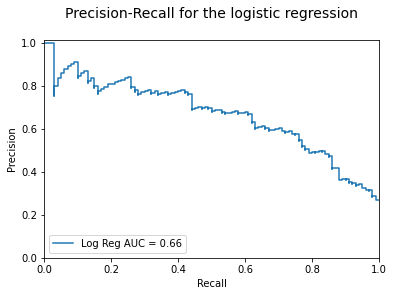

In [7]:
log_prec, log_rec, _ = precision_recall_curve(y_val, 
                                              y_pred_proba)

(PrecisionRecallDisplay(precision=log_prec, 
                        recall=log_rec)
 .plot(label='Log Reg AUC = %0.2f'% (auc(log_rec, 
                                         log_prec))))

plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.title('Precision-Recall for the logistic regression\n', 
          size=14);

### Model Validation and Optimization

If we compute an accuracy score on our test set, the result is dependent on how we split up the data! The data points in the test set may have some irregularities, which means that the accuracy computed on them is not typical of the model's ability to generalize to previously unseen data. To overcome this reliance on what is basically a random split, we employ a technique known as cross-validation. The dataset is randomly divided into 'k' groups when cross-validation is used. One of the groups is the test set, while the others are the training set. The model is trained using the training set, and it is scored using the test set. After that, the process is repeated until each separate group has been employed as the test set. As a result, cross validation allows our model to train on different train-test splits, providing us with a better understanding of how well our model will perform on unobserved data. Cross-validation requires more processing power and time to run than the holdout approach since it involves multiple train-test splits. Hold-out, on the other hand, is reliant on a single train-test split. As a result, the hold-out method score is affected by how the data is divided into train and test sets. 

We'll use 5 cross-validation to train and test our model(s) here. We'll pass our model, our data, and the number of splits to the `cross val score()` function, which will split our data into 5 groups and fit and score our data 5 times. It will save the accuracy score in an array each time. We'll use numpy's `.mean()` function to get the average accuracy score using these recorded accuracy scores. The average accuracy and standard deviation of each fold is $0.89 \pm 0.01$ which in fact is equal to the accuracy score we got earlier.

In [8]:
scores = cross_val_score(estimator=logreg, 
                         X=X_train, 
                         y=y_train, 
                         cv=10)
print('Accuracy = {:.2f} +/- {:.2f}'.format(scores.mean(), 
                                            scores.std()))

Accuracy = 0.89 +/- 0.01


Using `cross_val_score` is a convenient way to accomplish k-fold cross validation, but it doesn't tell us about the accuracies within each class. Since our problem is sensitive to each class' accuracy we will need to manually implement k-fold cross validation so that this information is available to us. In particular, we are interested in the accuracy of class 1, which represents the customers who accept this campaign's offer. Therefore, we'll define a function `cross_val_class_score()`. In the function, we implement k-fold cross validation manually using `StratifiedKFold()` class. This class takes the number of folds as an initialization argument and provides the `.split()` method to build randomly sampled masks for the data. In this instance, a mask is simply an array containing indexes of items in another array, where the items can then be returned by running code such as `data[mask]`. We use the indexes calculated from these masks to make a confusion matrix which we then use to calculate the accuracy scores for each fold. We return the list containing the accuracy scores as an array to allow for mathematical manipulations.

In [9]:
def cross_val_class_score(clf, X, y, cv=10):
    kfold = (StratifiedKFold(n_splits=cv, 
                             shuffle=True,
                             random_state=123).split(X, y))
    class_accuracy = []
    for k, (train, test) in enumerate(kfold):
        clf.fit(X.iloc[train], y.iloc[train])
        y_test2 = y.iloc[test]
        y_pred2 = clf.predict(X.iloc[test])
        
        cmat = confusion_matrix(y_test2, y_pred2)
        class_acc = cmat.diagonal()/cmat.sum(axis=1)
        class_accuracy.append(class_acc)
        print('fold: {:d} accuracy: {:s}'.format(k+1, 
                                                 str(class_acc)))
    return np.asarray(class_accuracy)

cross_val_class_score

<function __main__.cross_val_class_score(clf, X, y, cv=10)>

Having defined this function, we can now calculate the class accuracies with code that's very similar to `cross_val_score()` from before. The values returned corresponds to class 0 and the second correspond to class 1.

In [10]:
strat_scores = cross_val_class_score(logreg, X, y)
print()
print('Accuracy = {} +/- {}'\
      .format(strat_scores.mean(axis=0), 
              strat_scores.std(axis=0)))

fold: 1 accuracy: [0.97894737 0.44117647]
fold: 2 accuracy: [0.97894737 0.38235294]
fold: 3 accuracy: [0.94736842 0.47058824]
fold: 4 accuracy: [0.95263158 0.61764706]
fold: 5 accuracy: [0.97382199 0.63636364]
fold: 6 accuracy: [0.96335079 0.39393939]
fold: 7 accuracy: [0.95811518 0.51515152]
fold: 8 accuracy: [0.98429319 0.33333333]
fold: 9 accuracy: [0.97382199 0.45454545]
fold: 10 accuracy: [0.97382199 0.39393939]

Accuracy = [0.96851199 0.46390374] +/- [0.0117703  0.09494405]


Having seen k-fold cross validation in action, we'll move on to the topic of validation curves. These can be generated easily with scikit-learn. The `validation_curve()` function is used to calculate validation curves. This function uses stratified k-fold cross validation to train models for various
values of a specified hyperparameter. Here, we'll perform the calculations required to plot a validation curve. The function returns arrays with the cross validation (training and test) scores of models, where each has a different `C` variable. 

In [11]:
C_range = [0.01, 0.05, 0.1, 0.3, 0.5]
train_scores, test_scores =\
        validation_curve(estimator=logreg, 
                         X=X, 
                         y=y, 
                         param_name='classifier__C', 
                         param_range=C_range, 
                         cv=10)

To visualize the results, we'll define a function `plot_validation_curve()` whose complete code can be found [here](https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html) and [here](https://github.com/PacktWorkshops/The-Applied-Data-Science-Workshop/blob/master/chapter-05/chapter_5_workbook.ipynb).

In [12]:
def plot_validation_curve(train_scores, test_scores, 
                          param_range, xlabel='', 
                          log=False,):
    
    """This code is from scikit-learn docs (BSD License).
    It plots the validation curve scores together with the 
    standard deviations.
    """
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    fig = plt.figure(figsize=(8, 3.5))
    
    plt.plot(param_range, train_mean, 
             color=sns.color_palette('Set1')[1], marker='o', 
             markersize=5, label='training accuracy')

    plt.fill_between(param_range, train_mean + train_std,
                     train_mean - train_std, alpha=0.15,
                     color=sns.color_palette('Set1')[1])

    plt.plot(param_range, test_mean, 
             color=sns.color_palette('Set1')[0], linestyle='--', 
             marker='s', markersize=5, 
             label='validation accuracy')

    plt.fill_between(param_range, 
                     test_mean + test_std,
                     test_mean - test_std, 
                     alpha=0.15, color=sns.color_palette('Set1')[0])

    if log:
        plt.xscale('log')
    plt.legend(loc='lower right')
    if xlabel:
        plt.xlabel(xlabel)
    plt.ylabel('Accuracy')
    plt.ylim(0.9, 1.0)
    return fig

plot_validation_curve

<function __main__.plot_validation_curve(train_scores, test_scores, param_range, xlabel='', log=False)>

With the function defined, we can see that to some extent, the `C` parameter for logistic regression controls the balance between underfitting and overfitting. This is reflected in the validation curve,
where we can see low accuracies for small `C` values (underfitting), since we are not allowing the logistic regression to create enough regulation to capture the patterns in the data. For large `C` values to the right of the chart, we can see the opposite happen, as the logistic regression here overfit the training data. This is evidenced from the fact that our validation accuracy (red squares) decreases as the `C` increases and then levels off. Notice how the training accuracy (blue circles) and validation accuracy (red dots) continues increasing as the `C` increases until a point where they almost level off. This happens because the logistic regression is able to capture increasingly detailed patterns in the training data. By looking at the validation accuracies, we can see that these patterns do not generalize well for unseen data. Based on this chart, a good value for `C` appears to be 0.01. At this point, we can see that the validation accuracy has hit a maximum and that the training and validation accuracies are agreement (within error).

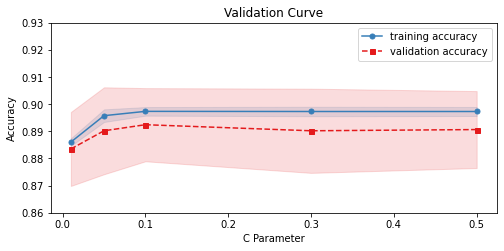

In [13]:
plot_validation_curve(train_scores,
                      test_scores,
                      C_range,
                      xlabel='C Parameter')
plt.ylim(0.86, 0.93)
plt.legend()
plt.title('Validation Curve');

To perform cross-validation we then create a `KFold()` object, instantiate a logistic regression model, and call `cross_val_score()`. 

We set `scoring` equal to `"neg_mean_squared_error"`, which returns the negative MSE. This is because scikit-learn's cross-validation metrics presume a higher score is better, so MSE is changed to negative to counteract this. We can calculate the training RMSE by taking the square root and converting to positive, achieved by calling numpy-dot-square-root and passing our scores with a minus sign in front.


Another method imported is `StratifiedKFold()`, which allows us to set a seed and shuffle our data, making our results repeatable downstream. Stratified k-fold cross validation maintains roughly even class
label populations in the folds. As we can imagine, this reduces the overall variance in the models and decreases the likelihood of highly unbalanced models causing bias.


We first call KFold. The n_splits argument has a default of five, but in this case we assign six, allowing us to use six folds from our dataset for cross-validation. We also set shuffle to True, which shuffles our dataset before splitting into folds. We also assign a seed to the random_state keyword argument, ensuring our data would be split in the same way if we repeat the process making the results repeatable downstream. We save this as the variable kf. As usual, we instantiate our model, in this case, linear regression. We then call cross_val_score, passing the model, the feature data, and the target data as the first three positional arguments. We also specify the number of folds by setting the keyword argument cv equal to our kf variable. This returns an array of cross-validation scores, which we assign to cv_results. The length of the array is the number of folds utilized. Note that the score reported is R squared, as this is the default score for linear regression.

## Hyperparameter Tuning

In this section, the model parameters are tuned to determine the best model parameters that can be used for prediction

In [14]:
param_rfc = { 
    'n_estimators': [50, 100, 200],
    'max_features': ['auto'],
    'max_depth' : [None,3,5,8],
    'criterion' :['gini'],
    'min_samples_split':[2,3,4]}

rfc_cv = GridSearchCV(RandomForestClassifier(random_state=5),gi
                            param_grid=param_rfc,
                            cv=5, verbose=1)

rfc_cv.fit(X_train, y_train)
rfc_tune_acc = pipe_fit_score(rfc_cv.best_estimator_)
print('Accuracy: ', rfc_tune_acc)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


C:\ProgramData\Anaconda3\envs\marketing_analytics\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
180 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
36 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\envs\marketing_analytics\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\envs\marketing_analytics\lib\site-packages\sklearn\ensemble\_forest.py", line 327, in fit
    X, y = self._validate_data(
  File "C:\ProgramData\Anaconda3\envs\marketing_analytics\lib\site-packages\sklearn\base.py", line 581,

ValueError: could not convert string to float: 'Graduation'

# **CLUSTERING FOR SEGMENTATION**

To avoid overlooking of customers' behavioral patterns, clustering will be used instead of personal intuitions during segmentation. For this case study, the criteria for segmentation is that regardless of marital status, and education level, the customers are separated based on their income level,  age, and purchase totals. Using these criteria, the results can be differential marketing strategy for customers that have, say, high income and low purchasing versus those with low income and high purchasing.

In [ ]:
cols = ['Income', 'Age', 'Purchase_total', 'Response']
marketing_clust = marketing[cols]

## Training and Validation Data

First the data is separated into training and testing portions to test for the accuracy of the clustering method used.

In [ ]:

X_data = marketing_clust.drop('Response', axis=1)
y_data = marketing_clust['Response']

X_train, X_test, y_train, y_test =\
    train_test_split(X_data, y_data, 
                     test_size=0.3, 
                     random_state=123)

X_train.shape, X_test.shape

## Standardization 

Next we standardize the training data and upon verification the mean value of practically all the columns is 0 and the standard deviation is 1. This ensures that all the columns get equal weight when calculation the similarity or distance between customers.

In [ ]:
from sklearn.preprocessing import StandardScaler
from warnings import filterwarnings
filterwarnings('ignore')

scaler = StandardScaler()

clust_cols = ['Income', 'Age', 'Purchase_total']
scaled_cols = ['Income_scaled', 'Age_scaled', 'Purchase_scaled']
X_train[scaled_cols] = scaler.fit_transform(X_train[clust_cols])

## Kmeans Clustering and Dimensionality Reduction

To choose an appropriate number clusters, the silhouttes score is used to measure how well a clustering fit the data. In this case, the higher score (optimal number of clusters) is from two clusters.

In [ ]:
from sklearn.cluster import KMeans

sil_scores = []

for k in range(2, 10):
    km_model = KMeans(n_clusters=k, random_state=123)
    cluster_assignments = km_model.fit_predict(X_train[scaled_cols])
    sil_scores.append(silhouette_score(X_train[scaled_cols], 
                                       cluster_assignments))

plt.plot(range(2, 10), sil_scores, color='#306958')
plt.ylabel('Avg. Silhouette score')
plt.xlabel('Number of Clusters: K');

## Evaluating KMeans Performance

A kmean model is created setting the number of clusters to 2 and fit to the training data in order to predict the clusters. The average silhouette score for this number of clusters is 0.51.

In [ ]:
km_model = KMeans(n_clusters=2, random_state=123)
X_train['Income_Clusters'] = (km_model
                              .fit_predict(X_train[scaled_cols]))

silhouette_score(X_train[clust_cols], X_train['Income_Clusters'])

For the test data, the average silhouette score (0.53) is an improvement from that computed for the training data (0.51).

In [ ]:
X_test[scaled_cols] = scaler.fit_transform(X_test[clust_cols])
X_test['Income_Clusters'] = (km_model
                             .predict(X_test[scaled_cols]))

silhouette_score(X_test[clust_cols], X_test['Income_Clusters'])

To understand the cause for this increase, a visualization will be created on the training and test data. But first, the data is reduced to two dimensions using PCA while preserving the distance between the points.

In [ ]:
from sklearn.decomposition import PCA

def pca_output(data):
    return PCA(n_components=2).fit_transform(data[scaled_cols])

pca_train = pca_output(X_train)
pca_test = pca_output(X_test)

X_train['pc1'], X_train['pc2'] = pca_train[:,0], pca_train[:,1]
X_test['pc1'], X_test['pc2'] = pca_test[:,0], pca_test[:,1]

Before going ahead, a function is defined to plot clusters.

In [ ]:
markers = ['.', 'x']
colors = ['#ed7d00', '#61b4f6']
alpha = [0.6, 0.6]

def plot_clusters(data):
    for clust in range(data['Income_Clusters'].nunique()):
        
        temp = data[data['Income_Clusters']==clust]
        
        plt.scatter(temp['pc1'], temp['pc2'], 
                    marker=markers[clust], 
                    label='cluster '+str(clust), 
                    color=colors[clust], 
                    alpha=alpha[clust])

    plt.legend(loc='upper left')
    plt.xlabel('PC1')
    plt.ylabel('PC2');

The x and y axes are Principal Components and therefore not easily interpretable being that they are derived from combinations of the original features. However, by visualizing the clusters, it is evident how good the clusters are based on how much they overlap. However, there is a data point that is far from its cluster.

In [ ]:
import seaborn as sns

plot_clusters(X_train)

The outlier is also evident in the average household income.

In [ ]:
sns.boxplot(X_train['Income'])
plt.title('Distribution of Income\n', size=13);

In the test data, the improvement of the average silhouette can be attributed to the tight clusters.

In [ ]:
plot_clusters(X_test)

To understand the clusters, the average values of the original features used for clustering can be computed against the two clusters visually. From the results it is clear that the income and purchase totals varies significantly between the clusters and perhaps for age.

In [ ]:
X_test.groupby('Income_Clusters')[clust_cols].mean()

## Interpreting Clusters

As an interpretation, cluster 0 can be said to be comprised of high income customers with high purchasing habits while cluster 1 consist of customers who have low income earner and thus lower spenders. The age difference is not that large but it is evident that those in cluster 0 are somewhat older than those in cluster 1. Note that for this visualization, the standardized values are used instead of the original feature values due to scaling.

In [ ]:
(X_test
 .groupby('Income_Clusters')[scaled_cols]
 .mean()
 .plot
 .bar(color=['#442e51', '#396d58', '#447ca4'], 
      alpha=0.8))

plt.axhline(0, 
            color='#aba396', 
            linestyle='--', 
            alpha=0.5)
plt.ylabel('Scaled Values')
plt.xlabel('Cluster')
plt.title('Customer Segmentation based on Income, Age, Purchase\n', 
          size=13);

With this information, it is evident that customers classified as low income earners and spenders have low conversion rate (10 percent against the overall 15 percent) while those categorized as high income earners and spenders have a high conversion rate (23 percent against the overall 15 percent).

In [ ]:
income_cluster = pd.concat([X_test['Income_Clusters'], 
                            y_test], 
                           axis=1)

(conversion_rate('Income_Clusters', income_cluster)
 .plot.barh())

plt.yticks(ticks=[0, 1], 
           labels=['Low-income & low spenders', 
                   'High-income & high spenders'])
plt.xlabel('Conversion Rate')
plt.ylabel('Cluster')
plt.title('Conversion Rate based on Income, Purchase & Age\n', 
          size=13);